# Basic analysis of a single ACCESS-OM3 run

In [1]:
from intake import cat
from xarray import DataTree, map_over_datasets
from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
test()

Functions from get_files.py imported!


Steps:
<!-- - In the gdata storage directory change the intake json file `cp intake_esm_ds.json intake_esm_ds_noah.json`
- `"file:///g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/archive/intake_esm_ds.csv.gz"`
 -->


Create a symbolic link (by default `archive` links to `/scratch/ps29/nd0349/access-om3/archive/mom6-cice6_ryf_rel_wav`):
- `rm /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive`
- `ln -s /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive`

In [2]:
# %%bash
# rm /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# ln -s /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_iaf_rel /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# # 1deg_jra55_iaf-expt-70159801

In [3]:
# %%bash
# rm /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# ln -s /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_iaf_rel /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# #mom6-cice6_ryf_rel_wav_rand

In [4]:
# %%bash
# rm /g/data/ps29/nd0349/spack/0.22/spack-release/access-om3/wav_config_iaf/archive
# ln -s /g/data/ps29/nd0349/runs/access-om3/archive/wav_config_iaf /g/data/ps29/nd0349/spack/0.22/spack-release/access-om3/wav_config_iaf/archive
# # wav_iaf_rel

In [5]:
from access_nri_intake.source import builders

builders.__all__

['AccessOm2Builder',
 'AccessOm3Builder',
 'Mom6Builder',
 'AccessEsm15Builder',
 'AccessCm2Builder',
 'ROMSBuilder',
 'WoaBuilder']

In [6]:
%%time
model = 'access-om3'
expt = 'wav_config_iaf'
PATH = f"/scratch/ps29/nd0349/{model}/archive/{expt}" #Some example ACCESS-OM2 output

builder = builders.AccessOm3Builder(
    path=PATH
).build()

CPU times: user 5.21 s, sys: 558 ms, total: 5.76 s
Wall time: 1min 4s


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/access_nri_intake/source/builders.py:203: UserWarning: Unable to parse 176 assets. A list of these assets can be found in `.invalid_assets` attribute.
  self.get_assets().validate_parser().parse().clean_dataframe()


In [7]:
builder.save(
    name="mydatastore", 
    description="An example datastore for ACCESS-OM3",
)

Successfully wrote ESM catalog json file to: file:///home/566/nd0349/mydatastore.json


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/pydantic/deprecated/decorator.py:227: UserWarning: Unable to parse 176 assets/files. A list of these assets can be found in /jobfs/150765468.gadi-pbs/mydatastore_invalid_assets.csv.
  return self.raw_function(**d, **var_kwargs)


In [8]:
# import pandas as pd

# # Load the CSV
# df = pd.read_csv('/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/intake_esm_ds.csv.gz')

# # Replace the old path with the new one
# old_path = "/g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive/output000/"
# new_path = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/"

# df['path'] = df['path'].str.replace(old_path, new_path)

# # Save the updated CSV
# df.to_csv('/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/intake_esm_ds_noah.csv.gz', index=False)



In [9]:
client = Client(threads_per_worker=1, memory_limit=0)
client

<Client: 'tcp://127.0.0.1:44567' processes=14 threads=14, memory=0 B>

In [10]:
import intake

esm_datastore = intake.open_esm_datastore(
    "./mydatastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

In [11]:
# import intake
# expt = "wav_config_iaf" #"mom6-cice6_ryf_rel_wav"
# model = "access-om3"

# esm_datastore = intake.open_esm_datastore(
#     f"/g/data/ps29/nd0349/runs/{model}/archive/{expt}/intake_esm_ds.json", 
#     columns_with_iterables=[
#             "variable",
#             "variable_long_name",
#             "variable_standard_name",
#             "variable_cell_methods",
#             "variable_units",
#     ], # This is important
#     # directory = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/"
#     # storage_options={"root": "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/"}
# )

# # esm_datastore.unique().path

In [12]:
# ds

In [13]:
esm_datastore.df.frequency.unique()

array(['1day', '1mon', 'fx'], dtype=object)

In [14]:
esm_datastore.unique().frequency
esm_datastore.search(frequency='fx').unique().variable#[0:100]
# esm_datastore.unique().variable

['Coriolis',
 'areacello',
 'areacello_bu',
 'areacello_cu',
 'areacello_cv',
 'cos_rot',
 'deptho',
 'geolat',
 'geolat_c',
 'geolat_u',
 'geolat_v',
 'geolon',
 'geolon_c',
 'geolon_u',
 'geolon_v',
 'sin_rot',
 'time',
 'wet',
 'wet_c',
 'wet_u',
 'wet_v',
 'xh',
 'xq',
 'yh',
 'yq',
 'EF',
 'FP0',
 'HS',
 'ICE',
 'ICEF',
 'ICEH',
 'T01',
 'T02',
 'T0M1',
 'THM',
 'UAX',
 'UAY',
 'USSX',
 'USSY',
 'mapsta',
 'CAu',
 'CAv',
 'DTBT',
 'First_direction',
 'Interface',
 'Kd_shear',
 'Kv_shear',
 'Layer',
 'MEKE',
 'MEKE_Kh',
 'MEKE_Kh_diff',
 'MEKE_Ku',
 'MLD_MLE_filtered',
 'Salt',
 'Temp',
 'Time',
 'age',
 'ave_ssh',
 'diffu',
 'diffv',
 'frazil',
 'h',
 'lath',
 'latq',
 'lonh',
 'lonq',
 'sfc',
 'u',
 'u2',
 'ubtav',
 'v',
 'v2',
 'vbtav']

In [15]:
# var = "aice"

# esm_datastore_filtered = esm_datastore.search(
#     variable=["aice_m", "fsdrad_m", "wave_sig_ht_m"], frequency="1mon", require_all_on="path"
# )
esm_datastore_filtered = esm_datastore.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], require_all_on="path"
)
esm_datastore_filtered

In [16]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
# var = 'aice'
ds_cice = esm_datastore_filtered.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]
ds_cice["time"] = ds_cice.time.to_pandas() - timedelta(hours=12)
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = np.degrees(grid_ds['tarea'])
ds_cice

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


CPU times: user 9.89 s, sys: 3.27 s, total: 13.2 s
Wall time: 23.6 s


<xarray.Dataset> Size: 5GB
Dimensions:      (time: 1492, nj: 300, ni: 360)
Coordinates:
  * time         (time) datetime64[ns] 12kB 1958-01-01 1958-01-02 ... 1962-01-31
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Dimensions without coordinates: nj, ni
Data variables:
    fsdrad       (time, nj, ni) float64 1GB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 1GB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 1GB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    hi           (time, nj, ni) float64 1GB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea        (nj, ni) float64 864kB 3.672e+10 3.672e+10 ... 2.2e+09
Attributes: (12/19)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,time: mean,time: mean,t...
    intake_esm_attrs:variable_units:          radians,radians,m,m,1,1,1,1,1/m...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   seaIce.1day.nbnd:2.nc:5.nf:12.n...

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Panel 1: aice
ds_cice['aice'].isel(time=-1).plot(ax=axes[0, 0])
axes[0, 0].set_title("aice")

# Panel 2: wave_sig_ht
ds_cice['wave_sig_ht'].isel(time=-1).plot(ax=axes[0, 1])
axes[0, 1].set_title("wave_sig_ht")

# Panel 3: hi
ds_cice['hi'].isel(time=-1).plot(ax=axes[1, 0])
axes[1, 0].set_title("hi")

# Panel 4: fsdrad
ds_cice['fsdrad'].isel(time=-1).plot(ax=axes[1, 1])
axes[1, 1].set_title("fsdrad")

plt.tight_layout()
plt.show()

In [18]:
ds_ww3 = esm_datastore.search(variable=["EF", "HS", "ICE", "ICEF", "ICEH"], require_all_on="path").to_dask()

#xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
# var = 'aice'
#ds = esm_datastore_filtered.to_dask(xarray_open_kwargs=xarray_open_kwargs)
# ds_ww3
ds_grid_ww3 = xr.open_dataset("/scratch/ps29/nd0349/access-om3/archive/wav_config_iaf/output000/access-om3.ww3.hi.1958-01-02-00000.nc")
ds_ww3.coords['lon'] = ds_grid_ww3['lon']
ds_ww3.coords['lat'] = ds_grid_ww3['lat']
ds_ww3

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.Dataset> Size: 19GB
Dimensions:  (time: 1492, ny: 300, nx: 360, freq: 25)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1958-01-02 1958-01-03 ... 1965-03-04
    lon      (ny, nx) float64 864kB ...
    lat      (ny, nx) float64 864kB ...
Dimensions without coordinates: ny, nx, freq
Data variables:
    HS       (time, ny, nx) float32 645MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 645MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEF     (time, ny, nx) float32 645MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 16GB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    ICEH     (time, ny, nx) float32 645MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'EF', 'IC...
    intake_esm_attrs:file_id:                 wave.fx.freq:25.nx:360.ny:300
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                EF,FP0,HS,ICE,ICEF,ICEH,T01,T02...
    intake_esm_attrs:variable_long_name:      1D spectral density,Peak freque...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          m2 s,s-1,m,nd,m,m,s,s,s,rad,m s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   wave.fx.freq:25.nx:360.ny:300

In [20]:
# ds_ww3.isel(time=time_idx).time

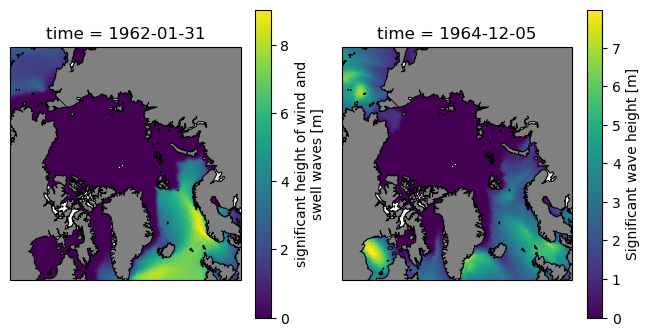

In [28]:
# ds_grid_ww3['lat'].plot()
time_idx = -90
time = ds_ww3.isel(time=time_idx).time.values

hemisphere = 'north'
fig, axes, projection = basic_axis([1,2], hemisphere=hemisphere)

data = ds_cice['wave_sig_ht'].sel(time=time, method='nearest')
data = data.assign_coords(
    TLON=ds_cice['TLON'],
    TLAT=ds_cice['TLAT']
)
data.plot(
    ax=axes[0], x="TLON", y="TLAT",
    # cmap=settings.get("cmap"),
    # vmin=settings.get("vmin"),
    # vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree()
)

# WW3 output
data = ds_ww3['HS'].sel(time=time)
data = data.assign_coords(
    lon=ds_ww3['lon'],
    lat=ds_ww3['lat']
)
data.plot(
    ax=axes[1], x="lon", y="lat",
    # cmap=settings.get("cmap"),
    # vmin=settings.get("vmin"),
    # vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree()
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 12.37 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'CICE – WW3')

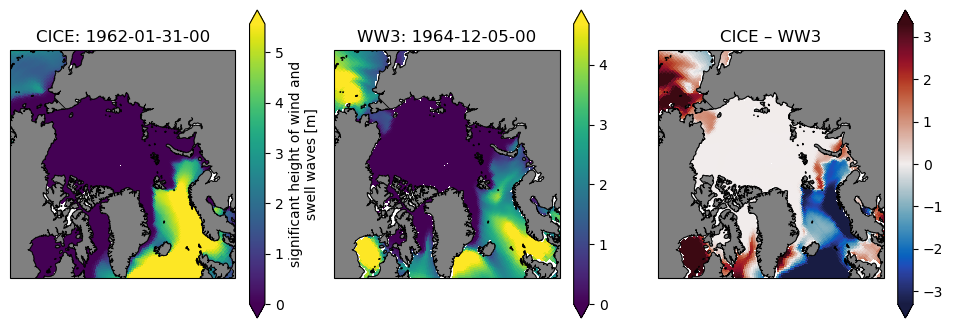

In [29]:
import xesmf as xe

time_idx = -90
time = ds_ww3.isel(time=time_idx).time.values

# --- Prepare datasets on native grids ---
cice = ds_cice['wave_sig_ht'].sel(time=time, method='nearest').assign_coords(
    lon=ds_cice['TLON'],
    lat=ds_cice['TLAT']
)

ww3 = ds_ww3['HS'].sel(time=time).assign_coords(
    lon=ds_ww3['lon'],
    lat=ds_ww3['lat']
)

# --- Build regridder to map CICE -> WW3 grid ---
regridder = xe.Regridder(
    ww3, cice, method="bilinear", periodic=False, reuse_weights=False
)

ww3_on_cice = regridder(ww3)

# --- Compute difference ---
diff = ww3_on_cice - cice

# --- Plot ---
fig, axes, projection = basic_axis([1, 3], hemisphere=hemisphere)

# WW3 (regridded)
cice.plot(
    ax=axes[0], x="lon", y="lat",
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    robust=True
)
time_str = pd.to_datetime(cice.time.values).strftime("%Y-%m-%d-%H")
axes[0].set_title(f"CICE: {time_str}")

# WW3
ww3_on_cice.plot(
    ax=axes[1], x="lon", y="lat",
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    robust=True
)
time_str = pd.to_datetime(ww3.time.values).strftime("%Y-%m-%d-%H")
axes[1].set_title(f"WW3: {time_str}")

# Difference
diff.plot(
    ax=axes[2], x="lon", y="lat",
    transform=ccrs.PlateCarree(),
    cmap=cmo.balance,
    robust=True
)
axes[2].set_title("CICE – WW3")

In [23]:
ds_ww3['HS'].isel(time=-1).plot()
plt.show()

In [24]:
x_idk = 110
time_idx = -1

latitudes = ds_cice['TLAT'].isel(ni=x_idk).values
latitudes_ww3 = ds_ww3['lat'].isel(nx=x_idk).values

fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis variables
ax1.plot(latitudes, ds_cice['wave_sig_ht'].isel(time=time_idx, ni=x_idk), color='blue', label='CICE', linestyle='-')
ax1.plot(latitudes_ww3, ds_ww3['HS'].isel(time=time_idx, nx=x_idk), color='blue', label='WW3', linestyle='--')
ax1.set_ylabel('$H_s$ [m]')
ax1.legend(loc='upper left')

# Right y-axis for aice
ax2 = ax1.twinx()
ax2.plot(latitudes, ds_cice['aice'].isel(time=time_idx, ni=x_idk), color='lightblue', label='CICE', linestyle='-')
ax2.plot(latitudes_ww3, ds_ww3['ICE'].isel(time=time_idx, nx=x_idk), color='lightblue', label='WW3', linestyle='--')
ax2.set_ylabel('SIC')
ax2.legend(loc='upper right')
ax2.set_ylim((0,1.1))

ax1.set_title('')
ax2.set_title('')
ax1.set_xlabel("Latitude [$^\circ$]")
time_val = pd.Timestamp(ds_cice.time[time_idx].values)
formatted_time = time_val.strftime("%Y-%m-%d %H:%M") 
plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())} / {np.round(ds_ww3['lon'].isel(nx=x_idk).values.mean())} E ({formatted_time})")
plt.show()

NameError: name 'longitudes' is not defined

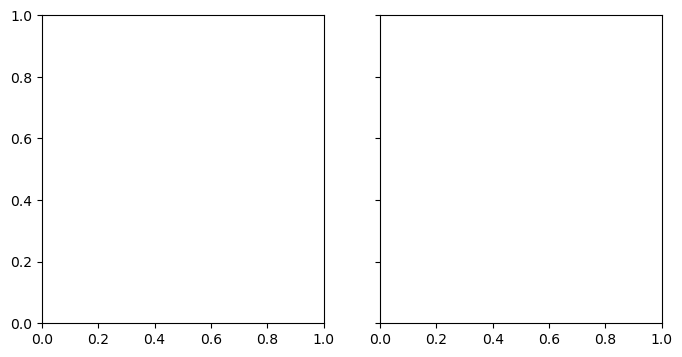

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)  # 1 row, 2 columns

# First subplot
axes[0].plot(latitudes, longitudes - longitudes_ww3)
axes[0].set_xlabel('Latitude [$^\circ$N]')
axes[0].set_ylabel('Longitude difference [$^\circ$E]')
axes[0].set_title('Longitude difference vs Latitude')

# Second subplot
axes[1].plot(longitudes, latitudes - latitudes_ww3)
axes[1].set_xlabel('Longitude [$^\circ$E]')
axes[1].set_ylabel('Latitude difference [$^\circ$N]')
axes[1].set_title('Latitude difference vs Longitude')

plt.tight_layout() 
plt.show()

In [ ]:
x_idk = 130

# Extract latitude
latitudes = -ds_cice['TLAT'].isel(ni=x_idk).compute().values

# Compute the mask: ice exists AND latitude < 0
mask_ice = ((ds_cice['aice'].isel(time=time_idx, ni=x_idk) > 0) & 
            (ds_cice['TLAT'].isel(ni=x_idk) < 0)).compute().values

# Extract wave heights and SIC as NumPy arrays
HS_in_ice = ds_ww3['HS'].isel(time=time_idx, nx=x_idk).compute().values[mask_ice]
wave_ht_in_ice = ds_cice['wave_sig_ht'].isel(time=time_idx, ni=x_idk).compute().values[mask_ice]
aice_in_ice = ds_cice['aice'].isel(time=time_idx, ni=x_idk).compute().values[mask_ice]
ice_in_ice = ds_ww3['ICE'].isel(time=time_idx, nx=x_idk).compute().values[mask_ice]
lat_masked = latitudes[mask_ice]

# Plot
fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis: wave heights
ax1.plot(lat_masked, wave_ht_in_ice, color='blue', label='CICE', linestyle='-')
ax1.plot(lat_masked, HS_in_ice, color='blue', label='WW3', linestyle='--')
ax1.set_ylabel('$H_s$ [m]')
ax1.legend(loc='upper left')

# Right y-axis: SIC (masked)
ax2 = ax1.twinx()
ax2.plot(lat_masked, aice_in_ice, color='lightblue', label='CICE')
ax2.plot(lat_masked, ice_in_ice, color='lightblue', label='WW3', linestyle='--')

ax2.set_ylabel('SIC')
ax2.set_ylim((0,1.1))
ax2.legend(loc='upper right')

ax1.set_yscale('log')

# Add vertical lines only for masked grid cells
for lat in lat_masked:
    ax1.axvline(lat, color='gray', linestyle=':', alpha=0.3)

plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())}° E")
ax1.set_xlabel('Latitude [°S]')
plt.show()

### Verify that floe sizes are consistent between models

In [ ]:
x_idk = 110
time_idx = -1

color1 = 'tab:red'
color2 = 'tab:purple'

latitudes = ds_cice['TLAT'].isel(ni=x_idk).values
latitudes_ww3 = ds_ww3['lat'].isel(nx=x_idk).values

fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis variables
ax1.plot(latitudes, ds_cice['fsdrad'].isel(time=time_idx, ni=x_idk), color=color1, label='CICE', linestyle='-')
ax1.plot(latitudes_ww3, ds_ww3['ICEF'].isel(time=time_idx, nx=x_idk), color=color1, label='WW3', linestyle='--')
ax1.set_ylabel('Floe size [m]', color=color1)
ax1.legend(loc='upper left')

# Right y-axis for aice
ax2 = ax1.twinx()
ax2.plot(latitudes, ds_cice['hi'].isel(time=time_idx, ni=x_idk), color=color2, label='CICE', linestyle='-')
ax2.plot(latitudes_ww3, ds_ww3['ICEH'].isel(time=time_idx, nx=x_idk), color=color2, label='WW3', linestyle='--')
ax2.set_ylabel('Ice thickness [m]', color=color2)
ax2.legend(loc='upper right')
# ax2.set_ylim((0,1.1))

ax1.set_title('')
ax2.set_title('')
ax1.set_xlabel("Latitude [$^\circ$]")
time_val = pd.Timestamp(ds_cice.time[time_idx].values)
formatted_time = time_val.strftime("%Y-%m-%d %H:%M") 
plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())} / {np.round(ds_ww3['lon'].isel(nx=x_idk).values.mean())} E ({formatted_time})")
plt.show()

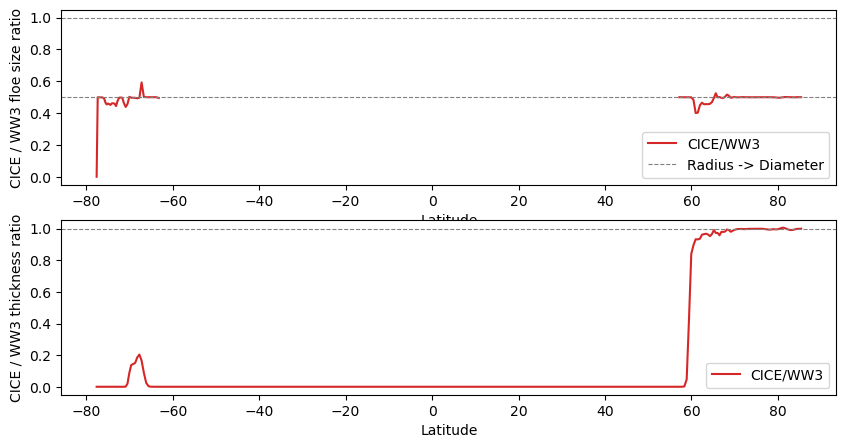

In [27]:
x_idk = 110
time_idx = -1

color1 = 'tab:red'
color2 = 'tab:purple'

latitudes = ds_cice['TLAT'].isel(ni=x_idk).values
latitudes_ww3 = ds_ww3['lat'].isel(nx=x_idk).values

fig, axes = plt.subplots(2, 1, figsize=(10,5))
ax1 = axes[0]
ax2 = axes[1]

# Extract data arrays
cice_vals = ds_cice['fsdrad'].isel(time=time_idx, ni=x_idk).values
ww3_vals = ds_ww3['ICEF'].isel(time=time_idx, nx=x_idk).values

# Interpolate WW3 onto CICE grid
ww3_interp = np.interp(latitudes, latitudes_ww3, ww3_vals)

# Avoid division by zero or invalids
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(ww3_interp != 0, cice_vals / ww3_interp, np.nan)

ax1.plot(latitudes, ratio, color=color1, linestyle='-', label='CICE/WW3')
ax1.set_ylabel('CICE / WW3 floe size ratio')
ax1.set_xlabel('Latitude')
ax1.axhline(1, color='gray', linestyle='--', lw=0.8)
ax1.axhline(0.5, color='gray', linestyle='--', lw=0.8, label='Radius -> Diameter')
ax1.legend()

# Extract data arrays
cice_vals = ds_cice['hi'].isel(time=time_idx, ni=x_idk).values
ww3_vals = ds_ww3['ICEH'].isel(time=time_idx, nx=x_idk).values

# Interpolate WW3 onto CICE grid
ww3_interp = np.interp(latitudes, latitudes_ww3, ww3_vals)

# Avoid division by zero or invalids
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(ww3_interp != 0, cice_vals / ww3_interp, np.nan)

ax2.plot(latitudes, ratio, color=color1, linestyle='-', label='CICE/WW3')
ax2.set_ylabel('CICE / WW3 thickness ratio')
ax2.set_xlabel('Latitude')
ax2.axhline(1, color='gray', linestyle='--', lw=0.8)
ax2.legend()



plt.show()
# # Right y-axis for aice
# ax2 = ax1.twinx()
# ax2.plot(latitudes, ds_cice['hi'].isel(time=time_idx, ni=x_idk), color=color2, label='CICE', linestyle='-')
# ax2.plot(latitudes_ww3, ds_ww3['ICEH'].isel(time=time_idx, nx=x_idk), color=color2, label='WW3', linestyle='--')
# ax2.set_ylabel('Ice thickness [m]', color=color2)
# ax2.legend(loc='upper right')
# # ax2.set_ylim((0,1.1))

# ax1.set_title('')
# ax2.set_title('')
# ax1.set_xlabel("Latitude [$^\circ$]")
# time_val = pd.Timestamp(ds_cice.time[time_idx].values)
# formatted_time = time_val.strftime("%Y-%m-%d %H:%M") 
# plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())} / {np.round(ds_ww3['lon'].isel(nx=x_idk).values.mean())} E ({formatted_time})")
# plt.show()

In [28]:
dsdsds

NameError: name 'dsdsds' is not defined

In [11]:
# # ds.isel(time=-1).plot()
# %matplotlib inline
# # ds
# if hemisphere == "south":
#         projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
#         lat_limits = [-90, -45]
# elif hemisphere == "north":
#     projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
#     lat_limits = [45, 90]
# else:
#     raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")

# fig, ax = plt.subplots(
#                      subplot_kw={'projection': projection},
#                      gridspec_kw={'wspace': 0.1, 'hspace': 0.15}) 

# ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

# ds.isel(time=-1).plot(
#         ax = ax,
#         x="TLON",
#         y="TLAT",
#         # cmap=settings.get("cmap"),
#         # vmin=settings.get("vmin"),
#         # vmax=settings.get("vmax"),
#         transform=ccrs.PlateCarree(),
#     )
# # plt.show()

## Make a quick movie

In [114]:
from io import BytesIO
import gc
import matplotlib
matplotlib.use("Agg")
import imageio.v3 as iio

plot_settings = {
    "aice": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "fsdrad": {"cmap": cmo.thermal, "vmin": 0, "vmax": 850},
    "hi": {"cmap": cmo.deep, "vmin": 0, "vmax": 5},
    "hs": {"cmap": cmo.amp, "vmin": 0, "vmax": 0.5},
    "hfs": {"cmap": cmo.amp, "vmin": 0, "vmax": 1},
    "tice": {"cmap": cmo.balance, "vmin": -30, "vmax": 0},
    "uvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "strength": {"cmap": cmo.matter, "vmin": 0, "vmax": 50e3},
    "divu": {"cmap": cmo.curl, "vmin": -1e-5, "vmax": 1e-5},
    "shear": {"cmap": cmo.curl, "vmin": 0, "vmax": 1e-5},
    "uocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "wave_sig_ht": {"cmap": cmo.tempo, "vmin": 0, "vmax": 10},  # Significant wave height
}

# Function to get plot settings for any variable
def get_plot_settings(var_name):
    # Remove common suffixes like "_m" (monthly), "_d" (daily), etc.
    base_var = re.sub(r"_(m|d|h|s|min|max|mean|std)$", "", var_name)
    
    # Check if the cleaned variable exists in settings
    return plot_settings.get(base_var, {"cmap": cmo.gray, "vmin": 0, "vmax": 1})  # Default if not found

def add_ice_contours(ax, ds_plot, hemisphere, projection):

    # if hemisphere=="north":
    transformed_coor=projection.transform_points(ccrs.PlateCarree(),ds_plot['TLON'].values,ds_plot['TLAT'].values)
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    use_transformed_coordinates_directly = True
    # inner_Arctic=xr.where(ds_plot['TLAT']>=81,1,0)
    ### Plot the selected snapshot 
    
    if use_transformed_coordinates_directly:
        cs = ax.contour(x_ster,y_ster,ds_plot['aice'],
                        levels=[0.15, 0.8],linestyles=["-", "--"],colors="magenta",linewidths=0.5
                       )
    else:
        cs = ax.contour(ds_plot['TLON'],ds_plot['TLAT'],ds_plot['aice'],levels=[0.15, 0.8],transform=ccrs.PlateCarree(),
                    linestyles=["-", "--"],colors="magenta",linewidths=0.5)
                
    return cs

def fancier_plot(ds_sel, time, var, hemisphere="south", cleanup=True):
    if hemisphere == "south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        lat_limits = [-90, -45]
    elif hemisphere == "north":
        projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
        lat_limits = [45, 90]
    else:
        raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")

    fig, ax = plt.subplots(
                         subplot_kw={'projection': projection},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

    # Add coastlines and land features
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                       edgecolor='black',
                                       facecolor='gray', linewidth=0.5)

    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

    # Get the settings for the selected variable, defaulting to None if not found
    settings = get_plot_settings(var)
    # print(settings.get("cmap"))
    # Apply the settings in the plot call
    ds_sel[var].plot(
        ax=ax,
        x="TLON",
        y="TLAT",
        cmap=settings.get("cmap"),
        vmin=settings.get("vmin"),
        vmax=settings.get("vmax"),
        transform=ccrs.PlateCarree(),
    )
    
    add_ice_contours(ax, ds_sel, hemisphere, projection)
    
    if cleanup:
        with BytesIO() as buf:
            fig.savefig(buf, format="png")
            plt.close(fig)
            image = iio.imread(buf.getvalue())
            
        # Clean up memory
        plt.close(fig)                  # Close the figure explicitly
        del fig, ax, ds_sel, settings   # Delete references to large objects
        gc.collect()                    # Force garbage collection

        return image



In [117]:
# ds_tmp.sel(time=time)

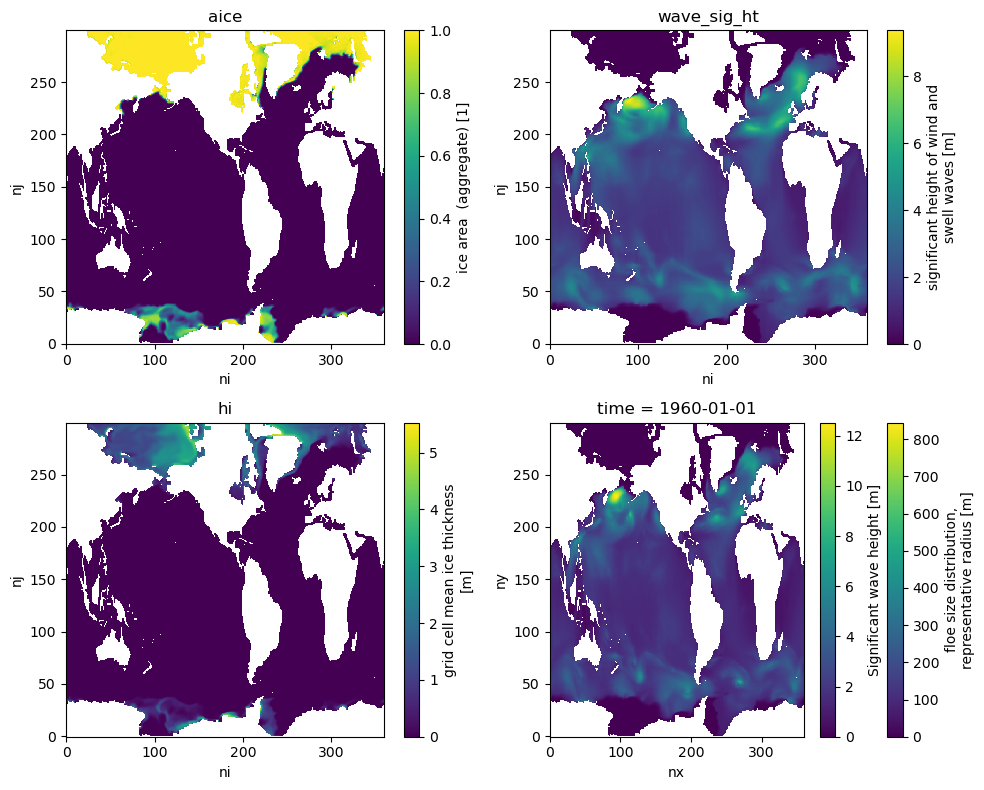

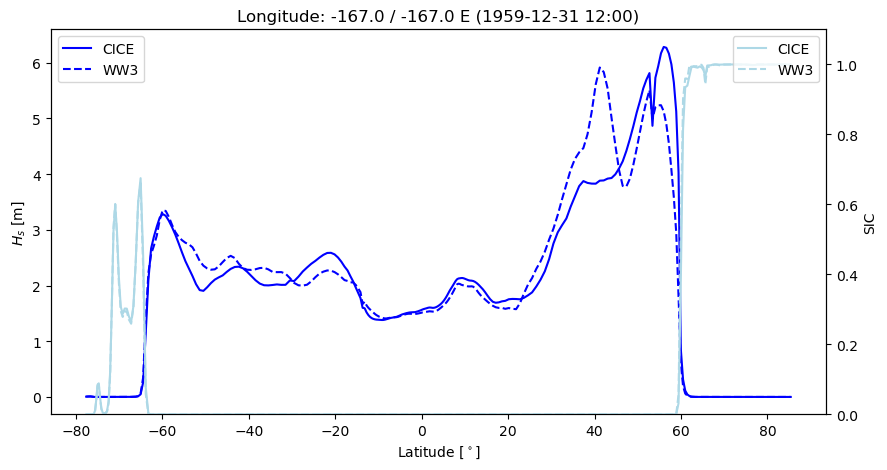

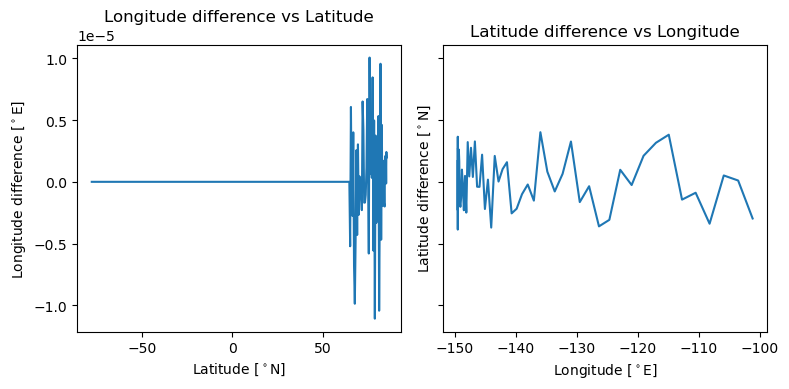

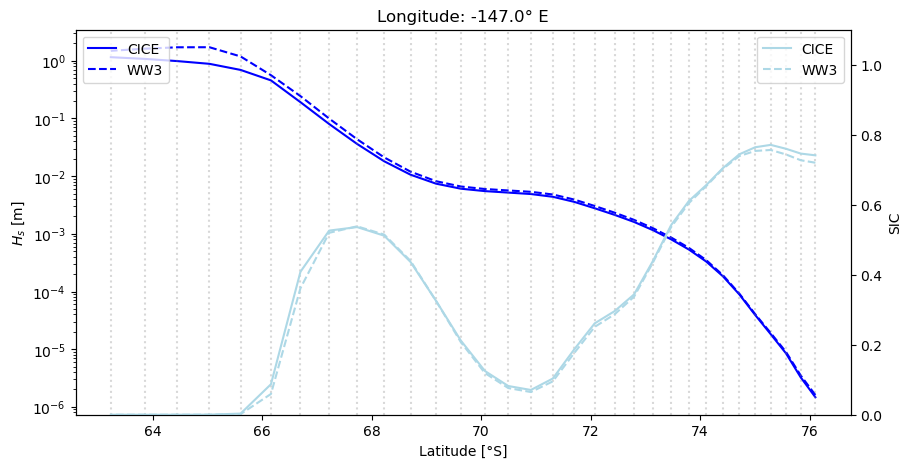

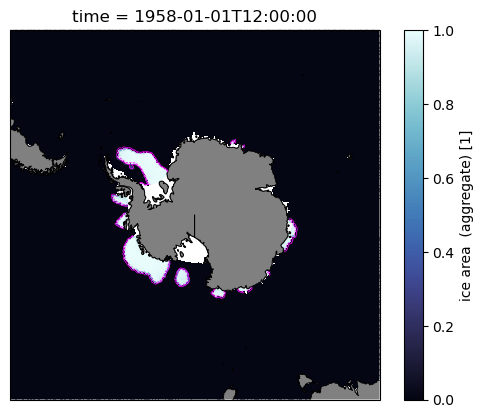

In [118]:
%matplotlib inline
var = 'aice'
time = ds_tmp["time"].values[0]
ds_tmp = ds.chunk({"time": 1, "ni": -1, "nj": -1})
fancier_plot(ds_tmp.sel(time=time), time, var, hemisphere, cleanup=False)

In [119]:
ds_tmp = ds_cice.chunk({"time": 1, "ni": -1, "nj": -1})#.isel(time=slice(0,-1,365))
ds_tmp

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 730, nj: 300, ni: 360)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1958-01-01T12:00:00 ... 1959-12-31...
    ulat         (nj, ni) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    ulon         (nj, ni) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    tlat         (nj, ni) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    tlon         (nj, ni) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    TLAT         (nj, ni) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Data variables:
    fsdrad       (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    hi           (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/19)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,time: mean,time: mean,t...
    intake_esm_attrs:variable_units:          radians,radians,m,m,1,1,1,1,1/m...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   seaIce.1day.nbnd:2.nc:5.nf:12.n...

In [120]:
%%time
import calendar
# month = 1
# var = "wave_sig_ht_m"
hemisphere = "south"
var = "wave_sig_ht"
model = "access-om3"
# expt = "wav_config_iaf"
ds = ds_cice.copy()
ds_tmp = ds.chunk({"time": 1, "ni": -1, "nj": -1})[var].isel(time=slice(0,-1,10))#['aice']
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds_tmp['TLON'] = np.degrees(grid_ds['tlon'])
ds_tmp['TLAT'] = np.degrees(grid_ds['tlat'])

futures = [
    client.submit(fancier_plot, ds_tmp.sel(time=time), time, var, hemisphere) for time in ds_tmp["time"].values
]

num_frames = len(futures)
duration_per_frame = 5 / num_frames  # 5 seconds total

with iio.imopen(f"/home/566/nd0349/access-om3-analysis/figures/{var}_{model}_{expt}_{hemisphere}.gif", 
                "w", extension=".gif") as f:
    for future in futures:
        image = future.result()
        f.write(image, duration=duration_per_frame)



2025-09-24 16:55:13,011 - distributed.worker - ERROR - Compute Failed
Key:       fancier_plot-9543203254a83955911fe9c19f052337
State:     executing
Task:  <Task 'fancier_plot-9543203254a83955911fe9c19f052337' fancier_plot(...)>
Exception: "KeyError('wave_sig_ht')"
Traceback: '  File "/jobfs/150672772.gadi-pbs/ipykernel_1879513/1291940833.py", line 79, in fancier_plot\n  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/core/dataarray.py", line 884, in __getitem__\n    return self._getitem_coord(key)\n           ^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/core/dataarray.py", line 878, in _getitem_coord\n    _, key, var = _get_virtual_variable(self._coords, key, dim_sizes)\n                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/core/dataset_utils

KeyError: 'wave_sig_ht'

2025-09-24 16:55:14,555 - distributed.worker - ERROR - Compute Failed
Key:       fancier_plot-ce3dd4928a5dc553d7246c0c888762b8
State:     executing
Task:  <Task 'fancier_plot-ce3dd4928a5dc553d7246c0c888762b8' fancier_plot(...)>
Exception: "KeyError('wave_sig_ht')"
Traceback: '  File "/jobfs/150672772.gadi-pbs/ipykernel_1879513/1291940833.py", line 79, in fancier_plot\n  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/core/dataarray.py", line 884, in __getitem__\n    return self._getitem_coord(key)\n           ^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/core/dataarray.py", line 878, in _getitem_coord\n    _, key, var = _get_virtual_variable(self._coords, key, dim_sizes)\n                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/core/dataset_utils

In [68]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 730, nj: 300, ni: 360)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1958-01-01T12:00:00 ... 1959-12-31...
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Dimensions without coordinates: nj, ni
Data variables:
    fsdrad       (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    hi           (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 631MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/19)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,time: mean,time: mean,t...
    intake_esm_attrs:variable_units:          radians,radians,m,m,1,1,1,1,1/m...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   seaIce.1day.nbnd:2.nc:5.nf:12.n...

In [85]:
%matplotlib inline
time = ds.isel(time=-1).time
var = "fsdrad"
fancier_plot(ds.isel(time=0), time, var, cleanup=False)
plt.show()

In [ ]:
ds.isel(time=-1)['aice'].plot()

## SIE and SIA

In [103]:
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"
nh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday"


def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds["cdr_conc"] = ds.cdr_conc.where(ds.cdr_conc<=1)  # convert error codes to Nan

    return ds

!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat")

# nh_cdr_xr = open_cdr_dataset(
#     nh_obs_url,
#     'psn25area_v3.dat'
# )

cdr_dt = DataTree.from_dict(
    {
        "cdr_sh": sh_cdr_xr,
        # 'cdr_nh':nh_cdr_xr
    }
)

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


In [104]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])
    
def sea_ice_area_model(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

def sea_ice_extent(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_extent_model(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

In [105]:
def sea_ice_area_obs(ds):

    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    sic = ds.cdr_conc
    result = sea_ice_area(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)
obs_area_dt = cdr_dt.map_over_datasets(sea_ice_area_obs)

In [106]:
def sea_ice_extent_obs(ds):

    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    sic = ds.cdr_conc
    result = sea_ice_extent(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)

In [109]:
obs_area_dt = sea_ice_area_obs(cdr_dt)
obs_extent_dt = sea_ice_extent_obs(cdr_dt)
obs_extent_dt['cdr_sh'].ds.cdr_area

AttributeError: 'DatasetView' object has no attribute 'cdr_area'

In [67]:
si_dt = sea_ice_area_model(ds_cice, ds_cice.tarea)
si_dt

<xarray.Dataset> Size: 29kB
Dimensions:      (time: 730)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1958-01-01T12:00:00 ... 1959-12-31...
Data variables:
    fsdrad       (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    aice         (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    hi           (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    wave_sig_ht  (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    tarea        float64 8B 0.0

In [68]:
# @map_over_subtree
def calculate_SIA_SIE_model(ds):
    # Compute for Southern Hemisphere
    sic_south = ds.aice.where(ds.TLAT < 0)
    area_south_km2 = grid_ds.tarea.where(ds.TLAT < 0) / 1e6
    si_area_south = sea_ice_area_model(sic_south, area_south_km2).to_dataset(name="si_area_south")
    si_extent_south = sea_ice_extent_model(sic_south, area_south_km2).to_dataset(name="si_extent_south")

    # Compute for Northern Hemisphere
    sic_north = ds.aice.where(ds.TLAT > 0)
    area_north_km2 = grid_ds.tarea.where(ds.TLAT > 0) / 1e6
    si_area_north = sea_ice_area_model(sic_north, area_north_km2).to_dataset(name="si_area_north")
    si_extent_north = sea_ice_extent_model(sic_north, area_north_km2).to_dataset(name="si_extent_north")

    # Merge both hemispheres into a single dataset
    return xr.merge([si_area_south, si_extent_south, si_area_north, si_extent_north]).load()


In [69]:
model_SIA_SIE_dt_FY = calculate_SIA_SIE_model(ds_cice.isel(time=slice(0,1*365)))
model_SIA_SIE_dt = calculate_SIA_SIE_model(ds_cice.isel(time=slice(10*365,20*365)))
model_SIA_SIE_dt_FY['si_extent_north']

<xarray.DataArray 'si_extent_north' (time: 365)> Size: 3kB
array([11262753.17210533, 11814681.02030779, 12104125.29174038,
       12445194.82375923, 12674391.84627915, 12869084.94399839,
       12976327.14030961, 13040086.78109453, 13105665.05741576,
       13183631.59055171, 13268138.1116958 , 13300058.07138619,
       13356435.08074556, 13368294.54620875, 13462997.83554867,
       13527521.99754303, 13538157.43830775, 13570927.61316373,
       13616782.83744474, 13644050.13876861, 13722462.78172117,
       13771089.89246551, 13815689.1620769 , 13819408.29425347,
       13827887.55685348, 13866221.39262191, 13897476.76376105,
       13944928.33343561, 13959476.32061794, 13967119.59456689,
       13981769.50041588, 14005062.55472473, 14032405.05390053,
       14029029.05052665, 14039247.95497774, 14074200.87107416,
       14107032.48559081, 14159640.45047122, 14192932.3333288 ,
       14223859.29702318, 14294791.19162171, 14336467.45923739,
       14345444.59368021, 14324731.16808403, 14348629.03770118,
       14403955.15532935, 14477255.86191739, 14480343.19764796,
       14471473.37528773, 14459714.43800867, 14487977.53583892,
       14520830.34040924, 14572324.94090322, 14605708.62021299,
       14641645.82485694, 14702786.61556276, 14737304.37968258,
       14791279.76286336, 14849301.44012367, 14848326.93077585,
...
       10171513.03910667, 10206420.51219413, 10247065.37383891,
       10278217.92982375, 10314536.30883895, 10349244.56731916,
       10379495.14671037, 10406284.16558415, 10440594.94549278,
       10462024.21307714, 10507475.32274156, 10550987.83028707,
       10615354.37346642, 10673432.53077801, 10750063.01429137,
       10825132.52715268, 10886881.41035289, 10911951.61091353,
       10942616.68127366, 10996722.490733  , 11056123.49659343,
       11124857.23721617, 11181558.14793762, 11226144.36563278,
       11291245.58905927, 11353946.64079229, 11422965.61118934,
       11541341.7570255 , 11615696.82571601, 11752433.61071445,
       11846280.72245265, 11990213.18028606, 12063558.9130284 ,
       12133621.59748365, 12211518.34352389, 12261416.9471669 ,
       12287719.62666579, 12329928.33295893, 12383034.58975183,
       12439137.65430606, 12467668.236533  , 12536507.75823317,
       12582089.5782248 , 12630605.9474817 , 12680524.17282454,
       12718097.40433404, 12732593.56637638, 12752031.2931802 ,
       12737849.55404023, 12770792.215026  , 12796091.10323856,
       12835980.33433606, 12873157.86885319, 12911998.86519179,
       12970598.82398334, 13005637.41443616, 13026631.81012345,
       13074555.91835276, 13094647.50066114])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1958-01-01T12:00:00 ... 1958-12-31T12:...

In [70]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

# Arctic
(model_SIA_SIE_dt_FY['si_extent_north'].groupby("time.month").mean()  * 1e-6).plot(ax=axes[0], label="First year", color='gray')
grouped = model_SIA_SIE_dt['si_extent_north'].groupby("time.month")
mean = grouped.mean() * 1e-6
std = grouped.std() * 1e-6
mean.plot(ax=axes[0], label="Mean after 10 year spinup")
axes[0].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
(obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[0], label="CDR", color='k')

# Antarctic
(model_SIA_SIE_dt_FY['si_extent_south'].groupby("time.month").mean()  * 1e-6).plot(ax=axes[1], label="First year", color='gray')
grouped = model_SIA_SIE_dt['si_extent_south'].groupby("time.month")
mean = grouped.mean() * 1e-6
std = grouped.std() * 1e-6
mean.plot(ax=axes[1], label="Mean")
axes[1].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
(obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[1], label="CDR", color='k')

# Labels
axes[0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
axes[1].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

axes[0].legend()

for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/SIE_{expt}.png", dpi=600, bbox_inches="tight") 
plt.show()

ValueError: month must not be empty

In [71]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

# Arctic
(model_SIA_SIE_dt_FY['si_extent_north']  * 1e-6).plot(ax=axes[0], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_north']
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[0], label="Mean after 10 year spinup")
# axes[0].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[0], label="CDR", color='k')

# Antarctic
(model_SIA_SIE_dt_FY['si_extent_south'] * 1e-6).plot(ax=axes[1], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_south'].groupby("time.month")
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[1], label="Mean")
# axes[1].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[1], label="CDR", color='k')

# Labels
axes[0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
axes[1].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

axes[0].legend()

for ax in axes:
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/SIE_{expt}.png", dpi=600, bbox_inches="tight") 
plt.show()

In [84]:

def sea_ice_area_model_sh(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    ds = ds.sel(nj=slice(0,150))
    sic = ds.aice
    area_km2 = ds.tarea / 1e6

    return sea_ice_area_model(sic, area_km2).to_dataset(name="si_area").load()

model_area_dt = sea_ice_area_model_sh(ds_cice)

## Calculate sea ice trends

In [112]:
def min_and_max_year(da):
    result = xr.Dataset()
    result["min"] = da.min()
    result["max"] = da.max()
    return result

def min_and_max(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds

    annual_min_max_ds = ds.si_area.groupby("time.year").apply(min_and_max_year)
    return annual_min_max_ds

# model_min_max_dt = model_area_dt.map_over_datasets(min_and_max)
model_min_max_dt = min_and_max(model_area_dt)

In [116]:
obs_area_dt["cdr_sh"].ds#.groupby("time.year").min()

<xarray.DatasetView> Size: 1GB
Dimensions:                           (time: 554, y: 332, x: 316)
Coordinates:
  * time                              (time) datetime64[ns] 4kB 1978-11-01 .....
  * y                                 (y) float32 1kB 4.338e+06 ... -3.938e+06
  * x                                 (x) float32 1kB -3.938e+06 ... 3.938e+06
    area                              (y, x) float64 839kB 444.1 445.0 ... 460.1
Data variables:
    cdr_conc                          (time, y, x) float32 232MB 0.0 0.0 ... 0.0
    nsidc_bt_seaice_conc_monthly      (time, y, x) float32 232MB ...
    nsidc_nt_seaice_conc_monthly      (time, y, x) float32 232MB ...
    qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 232MB ...
    stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 232MB ...
Attributes: (12/66)
    _NCProperties:                                       version=2,netcdf=4.8...
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2024-12-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [111]:
# for group in model_min_max_dt.groups[1:]:
    # ds = model_min_max_dt[group].ds
model_min_max_dt["min"].plot(label=expt)

obs_area_dt["cdr_sh"].ds.groupby("time.year").min().plot(label="CDR")

plt.title("Trends in Sea-Ice Minima")
plt.ylabel("Sea-Ice Area ($km^2$)")

_ = plt.legend()


KeyboardInterrupt

2025-09-24 17:45:54,522 - distributed.worker - ERROR - 
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/nanny.py", line 985, in run
    await worker.finished()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/core.py", line 494, in finished
    await self._event_finished.wait()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/utils.py", line 818, in wrapper
    return await func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/p

Error in callback <function _draw_all_if_interactive at 0x14e82064ce00> (for post_execute), with arguments args (),kwargs {}:


2025-09-24 17:45:54,792 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-09-24 17:45:54,843 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):

KeyboardInterrupt

  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/compatibility.py", line 204, in asyncio_run
    return runner.run(main)
           ^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/asyncio/base_events.py", line 641, in run_until_complete
    self.run_forever()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  

Error in callback <function flush_figures at 0x14e6eaf4cb80> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in atexit callback: <function end at 0x14880f6db100>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/pygmt/session_management.py", line 39, in end
    lib.call_module(module="end", args=[])
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/pygmt/clib/session.py", line 657, in call_module
    status = c_call_module(self.session_pointer, module.encode(), mode, argv)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
Exception ignored in atexit callback: <function end at 0x149b6d1e8c20>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/pygmt/session_management.py", line 39, in end
    lib.call_module(module="end", args=[])
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/pygmt/clib/se

KeyboardInterrupt: 

In [92]:
obs_area_dt

<xarray.DataTree>
Group: /
└── Group: /cdr_sh
        Dimensions:                           (time: 554, y: 332, x: 316)
        Coordinates:
          * time                              (time) datetime64[ns] 4kB 1978-11-01 .....
          * y                                 (y) float32 1kB 4.338e+06 ... -3.938e+06
          * x                                 (x) float32 1kB -3.938e+06 ... 3.938e+06
            area                              (y, x) float64 839kB 444.1 445.0 ... 460.1
        Data variables:
            cdr_conc                          (time, y, x) float32 232MB 0.0 0.0 ... 0.0
            nsidc_bt_seaice_conc_monthly      (time, y, x) float32 232MB ...
            nsidc_nt_seaice_conc_monthly      (time, y, x) float32 232MB ...
            qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 232MB ...
            stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 232MB ...
        Attributes: (12/66)
            _NCProperties:                                       version=2,netcdf=4.8...
            acknowledgement:                                     This project was sup...
            cdm_data_type:                                       Grid
            cdr_variable:                                        cdr_seaice_conc_monthly
            contributor_name:                                    Walter N. Meier, Flo...
            contributor_role:                                    principal investigat...
            ...                                                  ...
            summary:                                             This data set provid...
            time_coverage_duration:                              P1M
            time_coverage_end:                                   2024-12-01T00:00:00Z
            time_coverage_resolution:                            P1M
            time_coverage_start:                                 1978-11-01T00:00:00Z
            title:                                               Sea Ice Concentratio...

In [54]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Southern Hemisphere subplot
ax = axes[0]

    
if len(model_min_max_nh_dt["min"]) == 1:
    ax.scatter(model_min_max_nh_dt["min"].coords["year"], model_min_max_nh_dt["min"].values, label=iGroup[1:])
else:
    model_min_max_nh_dt["min"].plot(ax=ax, label=expt)
axes[0].set_title("Arctic")
# obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')


ax = axes[1]
if len(model_min_max_sh_dt["min"]) == 1:
    ax.scatter(model_min_max_sh_dt["min"].coords["year"], model_min_max_sh_dt["min"].values, label=iGroup[1:])
else:
    model_min_max_sh_dt["min"].plot(ax=ax, label=expt)
# obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')
axes[1].set_title("Antarctic")
# ax.set_ylabel("Sea Ice Area [km$^2$]")
# ax.set_title("Northern Hemisphere Sea Ice Minima")
# ax.legend()

plt.tight_layout()
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_min_subplot_{expt}.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'model_min_max_nh_dt' is not defined

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Southern Hemisphere subplot
ax = axes[0]

    
if len(model_min_max_nh_dt["max"]) == 1:
    ax.scatter(model_min_max_nh_dt["max"].coords["year"], model_min_max_nh_dt["max"].values, label=iGroup[1:])
else:
    model_min_max_nh_dt["max"].plot(ax=ax, label=expt)

axes[0].set_title("Arctic")
# obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')


ax = axes[1]
if len(model_min_max_sh_dt["max"]) == 1:
    ax.scatter(model_min_max_sh_dt["min"].coords["year"], model_min_max_sh_dt["max"].values, label=iGroup[1:])
else:
    model_min_max_sh_dt["max"].plot(ax=ax, label=expt)
axes[1].set_title("Antarctic")
# obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

# ax.set_ylabel("Sea Ice Area [km$^2$]")
# ax.set_title("Northern Hemisphere Sea Ice Minima")
# ax.legend()

plt.tight_layout()
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_max_subplot_{expt}.png", dpi=300, bbox_inches="tight")
plt.show()

## Compare two runs

In [12]:
import intake
expt1 = "mom6-cice6_ryf_rel_wav"
expt2 = "wav_iaf_rel"
model = "access-om3"

esm_datastore1 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{expt1}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)
esm_datastore2 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{expt2}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)

In [13]:
esm_datastore_filtered1 = esm_datastore1.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], #require_all_on="path"
)
esm_datastore_filtered1

In [14]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds1 = esm_datastore_filtered1.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]

grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds1['TLON'] = np.degrees(grid_ds['tlon'])
ds1['TLAT'] = np.degrees(grid_ds['tlat'])
ds1

CPU times: user 3.77 s, sys: 557 ms, total: 4.33 s
Wall time: 5.96 s


<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [15]:
esm_datastore_filtered2 = esm_datastore2.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], require_all_on="path"
)
esm_datastore_filtered2

In [16]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds2 = esm_datastore_filtered2.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]
# Add grid to dataset
ds2['TLON'] = np.degrees(grid_ds['tlon'])
ds2['TLAT'] = np.degrees(grid_ds['tlat'])
ds2

CPU times: user 366 ms, sys: 84.5 ms, total: 450 ms
Wall time: 664 ms


<xarray.Dataset> Size: 102MB
Dimensions:      (time: 28, nj: 300, ni: 360)
Coordinates:
  * time         (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-2...
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  This year has 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,time: mean,time: mea...
    intake_esm_attrs:variable_units:          days since 1958-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_XXXX_XX_XX.1day

In [17]:
# var = "aice"

# esm_datastore_filtered = esm_datastore.search(
#     variable=["aice_m", "fsdrad_m", "wave_sig_ht_m"], frequency="1mon", require_all_on="path"
# )
ds1

<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

ds1['aice'].isel(time=-1).plot(ax=axes[0])
ds2['aice'].isel(time=-1).plot(ax=axes[1])

plt.show()

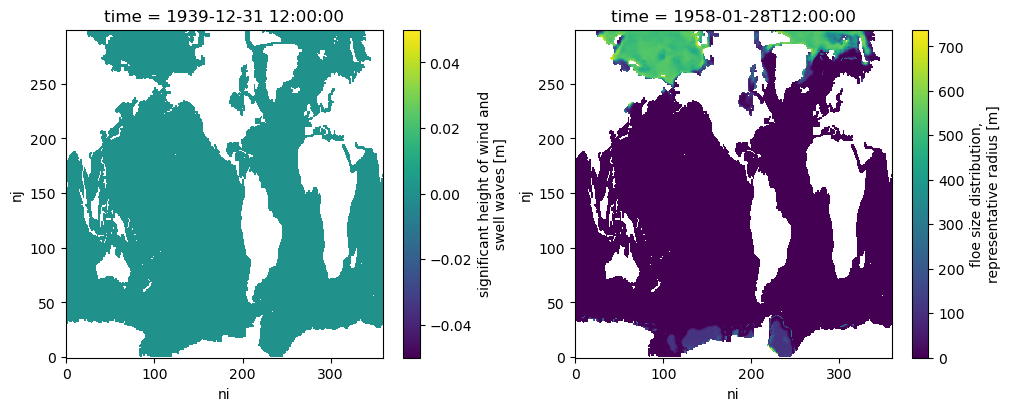

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

ds1['wave_sig_ht'].isel(time=-1).plot(ax=axes[0])
ds2['fsdrad'].isel(time=-1).plot(ax=axes[1])

plt.show()

In [20]:
%matplotlib inline
def basic_axis(dims, hemisphere="south"):
    if hemisphere=="south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        extent = [-180, 180, -90, -45]
    else:
        # projection = ccrs.NorthPolarStereo(true_scale_latitude=90)
        extent = [-180, 180, 60, 90]
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
            )
        
    # Determine number of rows and columns for subplots
    ncols = dims[1]#int(np.ceil(np.sqrt(number_panels)))
    nrows = dims[0]#int(np.ceil(number_panels / ncols))
    number_panels = ncols*nrows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        subplot_kw={'projection': projection},
        figsize=(4 * ncols, 4 * nrows),  # Adjust figure size
        gridspec_kw={'wspace': 0.15, 'hspace': 0.15}  # Adjust spacing
    )
    
    if number_panels == 1:
        axes = np.array([[axes]])  # Ensure axes is always a 2D array
    elif nrows == 1 or ncols == 1:
        axes = axes.reshape((nrows, ncols))
    
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='gray', linewidth=0.5)
    
    for ax in axes.flat[:number_panels]:  # Only iterate over required axes
        ax.set_global()
        ax.coastlines(resolution='50m')
        ax.add_feature(land_50m)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Hide unused subplots if necessary
    for ax in axes.flat[number_panels:]:
        ax.set_visible(False)
    axes = axes.flatten()
    return fig, axes, projection

def add_ice_contours(ax, ds_plot, hemisphere, projection):

    # if hemisphere=="north":
    transformed_coor=projection.transform_points(ccrs.PlateCarree(),ds_plot['TLON'].values,ds_plot['TLAT'].values)
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    use_transformed_coordinates_directly = True
    # inner_Arctic=xr.where(ds_plot['TLAT']>=81,1,0)
    ### Plot the selected snapshot 
    
    if use_transformed_coordinates_directly:
        cs = ax.contour(x_ster,y_ster,ds_plot['aice'],levels=[0.15, 0.8],linestyles=["-", "--"],colors="magenta",linewidths=0.5)
    else:
        cs = ax.contour(ds_plot['TLON'],ds_plot['TLAT'],ds_plot['aice'],levels=[0.15, 0.8],transform=ccrs.PlateCarree(),
                    linestyles=["-", "--"],colors="magenta",linewidths=0.5)
                
    # else:

    #     cs = ax.contour(
    #         ds_plot["TLON"], ds_plot["TLAT"], ds_plot["aice"],
    #         levels=[0.15, 0.8], linestyles=["-", "--"], colors="magenta", linewidths=1, transform=ccrs.PlateCarree()
    #     )
    return cs

In [21]:
ds1

<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [22]:
import socket

def get_path(experiments):
    hostname = socket.gethostname()
    if "gadi" in hostname:
        machine = "gadi"
        #path = "/g/data/ps29/nd0349/runs/cice6/"
        path = "/scratch/ps29/nd0349/CICE_RUNS/"
        fig_path = "/home/566/nd0349/access-om3-analysis/figures/"
    elif "setonix" in hostname:
        machine = "setonix"
    else:
        machine = "noahday"
        path = "/Users/noahday/GitHub/cice-dev/cice-dirs/runs/"
        fig_path = "/Users/noahday/GitHub/access-om3-analysis/figures/"

    print(f"Running on {machine}")
        
    return path, fig_path


experiment_sets = {
    "test": ["sandbox"], #["baseline-1deg", "nofsd-1deg", "wave-profile-1deg"], # "sandbox", "test"
    "gx3": ["baseline-gx3", "wave-constant-gx3", "wave-profile-gx3", "wave-random-gx3"],
    "baseline": ["baseline-1deg", "baseline-025deg"],
    "wave-1deg": ["nofsd-1deg"], # "wave-profile-1deg", "wave-random-1deg" , "nofsd-1deg"
    "temp": ["baseline-1deg", "wave-profile-1deg", "wave-propagation-1deg"],
}
expt = "wave-propagation-1deg"
expt_path, fig_path = get_path(expt)

histfreq = "d"
path = os.path.join(expt_path, expt, "history/")
if histfreq == "h":
    file_pattern = os.path.join(path, "iceh_01h.????-??-??-?????.nc")
    time_delta = timedelta(minutes=30)
elif histfreq == "d":
    file_pattern = os.path.join(path, "iceh.????-??-??.nc")
    time_delta = timedelta(hours=12)
elif histfreq == "m":
    file_pattern = os.path.join(path, "iceh.????-??.nc")  # Adjust this if needed
    time_delta = timedelta(days=16)
files = sorted(glob.glob(file_pattern))

basic_ice_vars = ["aice", "hi", "iage", "fsdrad"]
ocn_forcing_vars = ["sst", "sss", "uocn", "vocn"]
wave_forcing_vars = ["wave_sig_ht"] # peak period? MWD?

VARS = basic_ice_vars + ocn_forcing_vars + wave_forcing_vars
VARS_with_m = VARS + [var + "_m" for var in VARS]
VARS = VARS + VARS_with_m
keep_vars = ["TLAT", "TLON", "time", "tarea", "NFSD", "NCAT"] + VARS

sample_ds = xr.open_dataset(files[0])
drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
    
ds0 = xr.open_mfdataset(
        files,
        combine="by_coords",
        use_cftime=True,      # ensures all times use cftime objects
        drop_variables=drop_vars,
        decode_times=True,
    )


ds0

Running on gadi


<xarray.Dataset> Size: 787MB
Dimensions:      (time: 364, nc: 5, nf: 12, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 3kB 1958-01-02 00:00:00 ... 1958-12-31 00:00:00
    TLON         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    TLAT         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: nc, nf, nj, ni
Data variables:
    NCAT         (time, nc) float32 7kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    NFSD         (time, nf) float32 17kB dask.array<chunksize=(1, 12), meta=np.ndarray>
    tarea        (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    hi           (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    title:               sea ice model output for CICE
    contents:            Diagnostic and Prognostic Variables
    source:              Los Alamos Sea Ice Model, CICE_6.6.0
    comment:             This year has 365 days
    comment2:            File written on model date 19580102
    comment3:            seconds elapsed into model date:      0
    time_period_freq:    day_1
    time_axis_position:  end
    conventions:         CF-1.0
    history:             This dataset was created on 2025-07-25 at 13:03:50.2
    io_flavor:           io_netcdf

In [23]:
hemisphere = 'south'
aice_threshold = 0.01

fig, axes, projection = basic_axis([1,3], hemisphere=hemisphere)

# Axis 0: Standalone CICE6 with wave propagation
ax_idx = 0
ds_plot = ds0.isel(time=303) #dt[iGroup].isel(time=time_idx-1).copy()

ice_var = 'aice'
settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 1: MOM6-CICE6
ax_idx = 1
ds_plot = ds1.isel(time=151) #dt[iGroup].isel(time=time_idx-1).copy()

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 2: MOM6-CICE6-WW3
ax_idx = 2
ds_plot = ds2.isel(time=0)

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]

aice_mesh = data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]
wave_mesh = data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Add labels
axes[0].set_title("CICE6 w/ data waves (Nov)")
axes[1].set_title("MOM6-CICE6 w/o waves (June)")
axes[2].set_title("MOM6-CICE6-WW3 (Jan)")

# --- Shared colorbars ---
fig.subplots_adjust(right=0.9)

# Top colorbar axis (for aice)
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.35])  # [left, bottom, width, height]
cbar_aice = fig.colorbar(aice_mesh, cax=cax1, orientation="vertical")
cbar_aice.set_label("Sea ice concentration", fontsize=8)

# Bottom colorbar axis (for wave height)
cax2 = fig.add_axes([0.92, 0.1, 0.01, 0.35])
cbar_wave = fig.colorbar(wave_mesh, cax=cax2, orientation="vertical")
cbar_wave.set_label("Significant wave height [m]", fontsize=8)

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/cosima_poster_3maps_aice.png", dpi=300, bbox_inches="tight") 

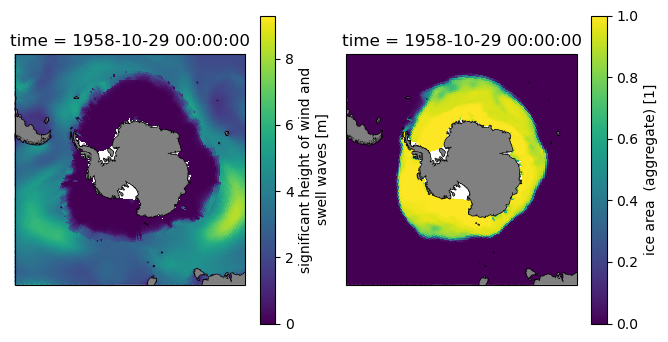

In [24]:
time_idx = 300

fig, axes, projection = basic_axis([1,2], hemisphere=hemisphere)
ds0.isel(time=time_idx)['wave_sig_ht'].plot(ax=axes[0], x="TLON", y="TLAT", transform=ccrs.PlateCarree())

ds0.isel(time=time_idx)['aice'].plot(ax=axes[1], x="TLON", y="TLAT", transform=ccrs.PlateCarree())

In [26]:
# vals0

### Calculate FSDs

In [27]:
NFSD = ds0.NFSD.isel(time=0)
BinWidths, BinLeft, BinRight = ciceBinWidths(NFSD)

bin_edges = np.concatenate([BinLeft, BinRight[-1:]])


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

aice_threshold = 0.15

# Mask and flatten the data for each dataset
vals0 = ds0.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds0["aice"] > aice_threshold)["fsdrad"].values.flatten()
vals1 = ds1.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds1["aice"] > aice_threshold)["fsdrad"].values.flatten()
vals2 = ds2.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds2["aice"] > aice_threshold)["fsdrad"].values.flatten()

# Drop NaNs
vals0 = vals0[~np.isnan(vals0)]
vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

datasets = [
    (vals0, "CICE6", "C0"),
    (vals1, "MOM6-CICE6", "C1"),
    (vals2, "MOM6-CICE6-WW3", "C2")
]

# Plot histograms with KDE
plt.figure(figsize=(8,6))

for vals, label, color in datasets:
    # Cumulative histogram
    plt.hist(vals, bins=bin_edges, density=True, cumulative=True,
             alpha=0.1, color=color, edgecolor=color, label=label)
    
    # KDE -> CDF
    kde = gaussian_kde(vals)
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    cdf = np.cumsum(kde(x_grid))
    cdf = cdf / cdf[-1]  # normalize to 1
    plt.plot(x_grid, cdf, color=color)

# sns.kdeplot(vals0, color="C0")

# sns.histplot(vals1, bins=bin_edges, stat="cumulative", alpha=0.3, color="C1", label="MOM6-CICE6", edgecolor=None)
# sns.kdeplot(vals1, color="C1")

# sns.histplot(vals2, bins=bin_edges, stat="cumulative", alpha=0.3, color="C2", label="MOM6-CICE6-WW3", edgecolor=None)
# sns.kdeplot(vals2, color="C2")

plt.xscale("log")
# plt.yscale("log")  # log scale on y-axis
plt.xlabel("fsdrad")
plt.ylabel("Cumulative density, $P(r_a > x)$")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
aice_threshold = 0.15

# Mask and flatten the data for each dataset
vals0 = ds0.isel(time=slice(0,28)).where(ds0["aice"] > aice_threshold).where(ds0["TLON"] < 0)["fsdrad"].values.flatten()
vals1 = ds1.isel(time=slice(0,28)).where(ds1["aice"] > aice_threshold).where(ds0["TLON"] < 0)["fsdrad"].values.flatten()
vals2 = ds2.isel(time=slice(0,28)).where(ds2["aice"] > aice_threshold).where(ds0["TLON"] < 0)["fsdrad"].values.flatten()

# Drop NaNs
vals0 = vals0[~np.isnan(vals0)]
vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

datasets = [
    (vals0, "CICE6", "C0"),
    (vals1, "MOM6-CICE6", "C1"),
    (vals2, "MOM6-CICE6-WW3", "C2"),
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 10), sharex=True, sharey=True)

for ax, (vals, label, color) in zip(axes, datasets):
    sns.histplot(vals, stat="density", alpha=0.3,
                 color=color, edgecolor=None, ax=ax)
    # ax.set_xscale("log")
    ax.set_ylabel("Density")
    ax.set_title(label)

axes[-1].set_xlabel("fsdrad")
plt.tight_layout()
plt.show()

In [32]:
aice_threshold = 0.15
hemisphere = 'north'
fig, axes, projection = basic_axis([1,3], hemisphere=hemisphere)

# Axis 0: Standalone CICE6 with wave propagation
ax_idx = 0
ds_plot = ds0.isel(time=274) #dt[iGroup].isel(time=time_idx-1).copy()

ice_var = 'aice'
settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 1: MOM6-CICE6
ax_idx = 1
ds_plot = ds1.isel(time=151) #dt[iGroup].isel(time=time_idx-1).copy()

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 2: MOM6-CICE6-WW3
ax_idx = 2
ds_plot = ds2.isel(time=0)

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]

aice_mesh = data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]
wave_mesh = data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Add labels
axes[0].set_title("CICE6 w/ data waves (Oct)")
axes[1].set_title("MOM6-CICE6 w/o waves (June)")
axes[2].set_title("MOM6-CICE6-WW3 (Feb)")

# --- Shared colorbars ---
fig.subplots_adjust(right=0.9)

# Top colorbar axis (for aice)
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.35])  # [left, bottom, width, height]
cbar_aice = fig.colorbar(aice_mesh, cax=cax1, orientation="vertical")
cbar_aice.set_label("Sea ice concentration", fontsize=8)

# Bottom colorbar axis (for wave height)
cax2 = fig.add_axes([0.92, 0.1, 0.01, 0.35])
cbar_wave = fig.colorbar(wave_mesh, cax=cax2, orientation="vertical")
cbar_wave.set_label("Significant wave height [m]", fontsize=8)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import gaussian_kde
import numpy as np

if hemisphere == "south":
    vals0 = ds0.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds0["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals1 = ds1.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds1["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals2 = ds2.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds2["aice"] > aice_threshold)["fsdrad"].values.flatten()
else:
    vals0 = ds0.isel(time=slice(0,28)).where(ds0["TLAT"] > 0).where(ds0["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals1 = ds1.isel(time=slice(0,28)).where(ds0["TLAT"] > 0).where(ds1["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals2 = ds2.isel(time=slice(0,28)).where(ds0["TLAT"] > 0).where(ds2["aice"] > aice_threshold)["fsdrad"].values.flatten()    

# Drop NaNs
vals0 = vals0[~np.isnan(vals0)]
vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

# Prepare the datasets
datasets_vals = [
    (ds0, vals0, "CICE6", "C0"),
    (ds1, vals1, "MOM6-CICE6", "C1"),
    (ds2, vals2, "MOM6-CICE6-WW3", "C2"),
]

# Add CDF insets
for ax_idx, (ds_plot, vals, label, color) in enumerate(datasets_vals):
    vals_clean = vals[~np.isnan(vals)]

    # Create inset axes inside the map axes
    ax_inset = inset_axes(
        axes[ax_idx],
        width="30%", height="30%",
        loc='lower left',           # anchor point in parent axes
        bbox_to_anchor=(0, 0, 1, 1),  # (x0, y0, width, height) relative to parent
        bbox_transform=axes[ax_idx].transAxes,  # use axes coords
        borderpad=0                 # no padding
    )

    # Cumulative histogram
    ax_inset.hist(vals_clean, bins=bin_edges, density=True, cumulative=True,
                  alpha=0.2, color=color, edgecolor=color)

    # KDE -> CDF
    kde = gaussian_kde(vals_clean)
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    cdf = np.cumsum(kde(x_grid))
    cdf = cdf / cdf[-1]  # normalize 0-1
    ax_inset.plot(x_grid, cdf, color=color)

    # Formatting
    ax_inset.set_xscale("log")
    ax_inset.text(0.05, 0.95, "$P(r_a < x)$", transform=ax_inset.transAxes,
                  fontsize=8, fontweight='bold', va='top', ha='left', color=color)
    ax_inset.tick_params(axis='both', which='major', labelsize=7)

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/cosima_poster_3maps_aice_{hemisphere}.png", dpi=300, bbox_inches="tight") 

In [31]:
data

<xarray.DataArray 'wave_sig_ht' (nj: 300, ni: 360)> Size: 864kB
dask.array<getitem, shape=(300, 360), dtype=float64, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1958-01-01T12:00:00
    ulat     (nj, ni) float64 864kB ...
    ulon     (nj, ni) float64 864kB ...
    tlat     (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.153 1.145 1.138
    tlon     (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.395 1.396 1.396
    TLON     (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.96 79.97 79.99
    TLAT     (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      significant height of wind and swell waves
    cell_measures:  area: tarea
    comment:        from attenuated spectrum in ice
    cell_methods:   time: mean
    time_rep:       averaged

In [77]:
model_SIA_SIE_dt_FY1 = calculate_SIA_SIE_model(ds1.isel(time=slice(0,1*365)))
model_SIA_SIE_dt1 = calculate_SIA_SIE_model(ds1.isel(time=slice(10*365,20*365)))

model_SIA_SIE_dt_FY2 = calculate_SIA_SIE_model(ds2.isel(time=slice(0,1*365)))
model_SIA_SIE_dt2 = calculate_SIA_SIE_model(ds2.isel(time=slice(10*365,20*365)))
model_SIA_SIE_dt_FY['si_extent_north']

<xarray.DataArray 'si_extent_north' (time: 28)> Size: 224B
array([11261377.30814985, 11810483.61510048, 12097719.72776173,
       12447515.97004096, 12670026.86218495, 12875635.09063233,
       12973809.95129554, 13034369.05466882, 13108536.20047786,
       13179508.40257313, 13272062.8912908 , 13301378.66141357,
       13354940.44316545, 13361314.54647644, 13459153.9925322 ,
       13517838.72632424, 13527243.93220372, 13571248.35599424,
       13628840.31218697, 13639773.86567858, 13721192.85420104,
       13778781.80138021, 13806529.41914028, 13806193.22733291,
       13818787.43827989, 13852720.36942018, 13898196.96927123,
       13939768.85823385])
Coordinates:
  * time     (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-28T12...

In [88]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex=False)

# Arctic
(model_SIA_SIE_dt_FY1['si_extent_north']  * 1e-6).plot(ax=axes[0,0], label="First year", color='gray')
(model_SIA_SIE_dt_FY2['si_extent_north']  * 1e-6).plot(ax=axes[0,1], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_north']
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[0], label="Mean after 10 year spinup")
# axes[0].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[0], label="CDR", color='k')

# Antarctic
(model_SIA_SIE_dt_FY1['si_extent_south'] * 1e-6).plot(ax=axes[1,0], label="First year", color='gray')
(model_SIA_SIE_dt_FY2['si_extent_south'] * 1e-6).plot(ax=axes[1,1], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_south'].groupby("time.month")
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[1], label="Mean")
# axes[1].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[1], label="CDR", color='k')

# Labels
axes[0,0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
axes[1,0].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

axes[0,0].legend()

for ax in axes.flatten():
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/SIE_two_run_{expt1}_{expt2}.png", dpi=600, bbox_inches="tight") 
plt.show()

In [93]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharex=False)

# Arctic
ds1['wave_sig_ht'].mean(dim=['ni', 'nj']).plot(ax=axes[0], label="First year", color='gray')
ds2['wave_sig_ht'].mean(dim=['ni', 'nj']).plot(ax=axes[1], label="First year", color='gray')


# Labels
# axes[0,0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
# axes[1,0].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

# axes[0,0].legend()

for ax in axes.flatten():
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/SWH_two_run_{expt1}_{expt2}.png", dpi=600, bbox_inches="tight") 
plt.show()

In [83]:
model_SIA_SIE_dt_FY1['si_extent_north'].plot()

In [80]:
model_SIA_SIE_dt_FY2['time']

<xarray.DataArray 'time' (time: 28)> Size: 224B
array(['1958-01-01T12:00:00.000000000', '1958-01-02T12:00:00.000000000',
       '1958-01-03T12:00:00.000000000', '1958-01-04T12:00:00.000000000',
       '1958-01-05T12:00:00.000000000', '1958-01-06T12:00:00.000000000',
       '1958-01-07T12:00:00.000000000', '1958-01-08T12:00:00.000000000',
       '1958-01-09T12:00:00.000000000', '1958-01-10T12:00:00.000000000',
       '1958-01-11T12:00:00.000000000', '1958-01-12T12:00:00.000000000',
       '1958-01-13T12:00:00.000000000', '1958-01-14T12:00:00.000000000',
       '1958-01-15T12:00:00.000000000', '1958-01-16T12:00:00.000000000',
       '1958-01-17T12:00:00.000000000', '1958-01-18T12:00:00.000000000',
       '1958-01-19T12:00:00.000000000', '1958-01-20T12:00:00.000000000',
       '1958-01-21T12:00:00.000000000', '1958-01-22T12:00:00.000000000',
       '1958-01-23T12:00:00.000000000', '1958-01-24T12:00:00.000000000',
       '1958-01-25T12:00:00.000000000', '1958-01-26T12:00:00.000000000',
       '1958-01-27T12:00:00.000000000', '1958-01-28T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-28T12...
Attributes:
    long_name:  time
    bounds:     time_bounds

In [91]:
ds1['wave_sig_ht'].mean(dim=['ni', 'nj'])

<xarray.DataArray 'wave_sig_ht' (time: 28)> Size: 224B
dask.array<mean_agg-aggregate, shape=(28,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 224B 1900-01-01 12:00:00 ... 1900-01-28 12:00:00

### Compare a few runs in SIE and against OBS

In [69]:

def open_by_experiment(exp_name, vars, VARS_2D, RUN_DICT, catalog):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""

    print(f"Loading... {exp_name}")
    
    if RUN_DICT[exp_name]["model"] in ["access-om2", "access-om3"]:
        # If the experiment is in the Catalog then get the data from there
        # get the data for each run of this config
        cice_ds = xr.concat(
            [open_by_name(iName, vars, catalog) for iName in [RUN_DICT[exp_name]['expt']]], dim="time"
        )
    
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.merge(
            [
                xr.open_dataset(
                    catalog[RUN_DICT[exp_name]['expt']]
                    .search(variable=iVar)
                    .df.path[0]
                    # path of the first file with the area field, the geolon field and the geolat field
                ).drop_vars("time")
                for iVar in VARS_2D
            ]
        )
    
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
    
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
    
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
    
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
    
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
    
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    
    elif RUN_DICT[exp_name]["model"] == "access-om2-dev":
        # Else, it is a development expt and stored on ps29
        base_dir = f"/g/data/ps29/nd0349/runs/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # Extract most recent simulation
        if output_dirs:
            output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
            output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        else:
            output_number = "000"  # Default if no directories exist

        most_recent_file = False
        if most_recent_file:
            print(f"Output folder: {output_number}")
            files = sorted(glob.glob(file_pattern))
        else:
            all_files = []
            for output_dir in output_dirs:
                file_pattern = os.path.join(output_dir, "ice/OUTPUT/", "iceh.????-??.nc")
                all_files.extend(glob.glob(file_pattern))
            files = sorted(all_files)
        
        # path = os.path.join(base_dir, f"output{output_number}", "ice/OUTPUT/")
        # file_pattern = os.path.join(path, "iceh.????-??.nc")
        # files = sorted(glob.glob(file_pattern))
        # file_list = sorted(glob.glob(file_pattern))
        # print(file_pattern)
        # print(files)
        sample_ds = xr.open_mfdataset(files[0],combine="by_coords")

        # List of variables to keep
        keep_vars = ["TLAT", "TLON", "time"] + vars
        
        drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
        
        cice_ds = xr.open_mfdataset(
            files, 
            combine="by_coords", 
            decode_timedelta=False,
            drop_variables=drop_vars  # Now using the correct list
        )
        
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
        
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)


    
    elif RUN_DICT[exp_name]["model"] == "access-om3-dev":
        # Else, it is a development expt and stored on ps29
        most_recent_file = False
        run_status = 'archive' # 'archive' or 'work'
        if run_status == 'work':
            print("Using work directory")
            base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/work/{RUN_DICT[exp_name]['expt']}/"
            file_pattern = os.path.join(base_dir, "access-om3.cice.1mon.mean.????-??.nc")
        else:
        
            base_dir = f"/g/data/ps29/nd0349/runs/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
            # base_dir = f" /g/data/ps29/nd0349/access-om2/archive/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
           
            output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
            # Extract most recent simulation
            if output_dirs:
                output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
                output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
            else:
                output_number = "000"  # Default if no directories exist
            
            file_pattern = os.path.join(base_dir, f"output{output_number}", "access-om3.cice.1mon.mean.????-??.nc")

        if most_recent_file:
            print(f"Output folder: {output_number}")
            files = sorted(glob.glob(file_pattern))
        else:
            all_files = []
            for output_dir in output_dirs:
                file_pattern = os.path.join(output_dir, "access-om3.cice.1mon.mean.????-??.nc")
                all_files.extend(glob.glob(file_pattern))
            files = sorted(all_files)
        
        
        sample_ds = xr.open_mfdataset(files[0],combine="by_coords")

        # List of variables to keep
        keep_vars = ["TLAT", "TLON", "time"] + vars
        
        drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
        
        cice_ds = xr.open_mfdataset(
            files, 
            chunks={'ni':-1,'nj':-1,'time':120},
            combine="by_coords", 
            decode_timedelta=False,
            drop_variables=drop_vars  # Now using the correct list
        )
        
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc",
                                    drop_variables=["ulat","ulon"],
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]

        def radians_to_degrees(da):
            return da * (180 / np.pi)
        
        # Apply conversion efficiently while handling Dask arrays
        area_ds = area_ds.assign_coords(
            geolat_t=xr.apply_ufunc(radians_to_degrees, area_ds.geolat_t, dask="parallelized"),
            geolon_t=xr.apply_ufunc(radians_to_degrees, area_ds.geolon_t, dask="parallelized")
        )

        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
# plt.pcolormesh(all_data[1].geolon_t, all_data[1].geolat_t, all_data[1], shading='auto')

        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )


        
        # cice timestamps are also misleading:
        # cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    elif RUN_DICT[exp_name]["model"] == "access-om3-wav-dev":
        # ACCESS-OM3 development
        base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # # Extract most recent simulation
        # if output_dirs:
        #     output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
        #     output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        # else:
        #     output_number = "000"  # Default if no directories exist
        
        # path = os.path.join(base_dir, f"output{output_number}")
        # file_pattern = os.path.join(path, "access-om3.cice.*.nc")
        # files = sorted(glob.glob(file_pattern))
        # file_list = sorted(glob.glob(file_pattern))

        file_pattern = os.path.join(base_dir, "output[0-9][0-9][0-9]", "access-om3.cice.*.nc")
        file_list = sorted(glob.glob(file_pattern))
        print(file_list)
        # Read in data
        if file_list:
            cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        else:
            print("No matching files found.")


        # Read in data
        # cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        # cice_ds['aice_m'] = cice_ds['aice'].resample(time='ME').max()
        cice_ds['aice_m'] = cice_ds['aice']
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", 
                                   "nj": "yt_ocean", 
                                   "tarea": "area_t", 
                                   "tlat": "geolat_t", 
                                   "tlon": "geolon_t"})
                                )
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
        
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)
    print(f"{exp_name} loaded.")
    return cice_ds

In [70]:
# si_dt['ACCESS-OM2-10 JRA55-do IAF [dev]']

In [59]:
%%time
catalog = cat.access_nri

RUN_DICT = {
    # "ACCESS-OM2-10 JRA55-do IAF OMIP2": {"expt": "1deg_jra55_iaf_omip2_cycle1", "model": "access-om2"},
    # "ACCESS-OM2-10 JRA55-do RYF [dev]": {"expt": "1deg_jra55_ryf-expt-054ea9ee", "model": "access-om2-dev"},
    # "ACCESS-OM2-10 JRA55-do IAF [dev]": {"expt": "1deg_jra55_iaf-expt-70159801", "model": "access-om2-dev"},
    # "ACCESS-OM3-10 JRA55-do RYF [dev]": {"expt": "1deg_mom6_cice6_ryf", "model": "access-om3-dev"},
    # "ACCESS-OM3-10 JRA55-do IAF [dev]": {"expt": "1deg_mom6_cice6_iaf", "model": "access-om3-dev"},
    "ACCESS-OM3-025 JRA55-do IAF [dev]": {"expt": "mom6-cice6_ryf_025deg_rel", "model": "access-om3-dev"},
    "ACCESS-OM3-10-wave JRA55-do IAF [dev]": {"expt": "wav_iaf_rel", "model": "access-om3-wav-dev"},
}

VARS = ["aice_m", "hi_m" ]  # ice area fraction or sea ice concentration, ice thickness averaged by grid cell area
VARS_2D = ["area_t", "geolat_t", "geolon_t"]

si_name_ds_pairs = [(iRun, open_by_experiment(iRun, VARS, VARS_2D, RUN_DICT, catalog)) for iRun in RUN_DICT.keys()]

si_dt = DataTree.from_dict(dict(si_name_ds_pairs))
model_area_dt = si_dt.map_over_datasets(sea_ice_area_model_sh)

ValueError: conflicting sizes for dimension 'ni': length 360 on 'ni' and length 1440 on {'time': 'hi_m', 'nj': 'hi_m', 'ni': 'hi_m'}

In [68]:
import intake
expt1 = "1deg_jra55_iaf-expt-70159801"
expt2 = "mom6-cice6_iaf_rel"
# expt1 = "mom6-cice6_ryf_rel_wav"
# expt2 = "wav_iaf_rel"
model1 = "access-om2"
model2 = "access-om3"

esm_datastore1 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{expt1}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)
esm_datastore2 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{expt2}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_jra55_iaf-expt-70159801/intake_esm_ds.json'

In [5]:
esm_datastore_filtered1 = esm_datastore1.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], #require_all_on="path"
)
esm_datastore_filtered1

In [6]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds1 = esm_datastore_filtered1.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]

grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds1['TLON'] = np.degrees(grid_ds['tlon'])
ds1['TLAT'] = np.degrees(grid_ds['tlat'])
ds1

CPU times: user 7.96 s, sys: 1.95 s, total: 9.91 s
Wall time: 34.6 s


<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [7]:
esm_datastore_filtered2 = esm_datastore2.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], require_all_on="path"
)
esm_datastore_filtered2

In [8]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds2 = esm_datastore_filtered2.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]
# Add grid to dataset
ds2['TLON'] = np.degrees(grid_ds['tlon'])
ds2['TLAT'] = np.degrees(grid_ds['tlat'])
ds2

CPU times: user 310 ms, sys: 38.8 ms, total: 349 ms
Wall time: 738 ms


<xarray.Dataset> Size: 102MB
Dimensions:      (time: 28, nj: 300, ni: 360)
Coordinates:
  * time         (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-2...
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  This year has 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,time: mean,time: mea...
    intake_esm_attrs:variable_units:          days since 1958-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_XXXX_XX_XX.1day

In [9]:
# var = "aice"

# esm_datastore_filtered = esm_datastore.search(
#     variable=["aice_m", "fsdrad_m", "wave_sig_ht_m"], frequency="1mon", require_all_on="path"
# )
ds1

<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...